In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("new cases dataset.csv", index_col='date', parse_dates=True)
print('shape',dataset.shape)
dataset.describe()

shape (500, 11)


,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,stringency_index
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,500.000000
mean,52728.956000,204.206000,383.742000,1.646000,1.122480,0.068814,2.869641e+04,24776.272000,3920.140000,241.36000,47.446220
std,32793.093696,296.233164,281.213438,3.354876,0.263627,0.061634,1.613339e+05,133943.541915,39060.971015,3144.28997,12.460919
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,26460.250000,0.000000,142.750000,0.000000,0.997500,0.023000,0.000000e+00,0.000000,0.000000,0.00000,38.890000
50%,50544.000000,89.000000,323.000000,0.000000,1.170000,0.045000,0.000000e+00,0.000000,0.000000,0.00000,44.440000
75%,89893.000000,281.250000,734.000000,2.000000,1.252500,0.100000,0.000000e+00,0.000000,0.000000,0.00000,52.780000
max,102103.000000,1583.000000,823.000000,28.000000,1.550000,0.319000,1.271393e+06,865422.000000,405971.000000,48252.00000,86.110000


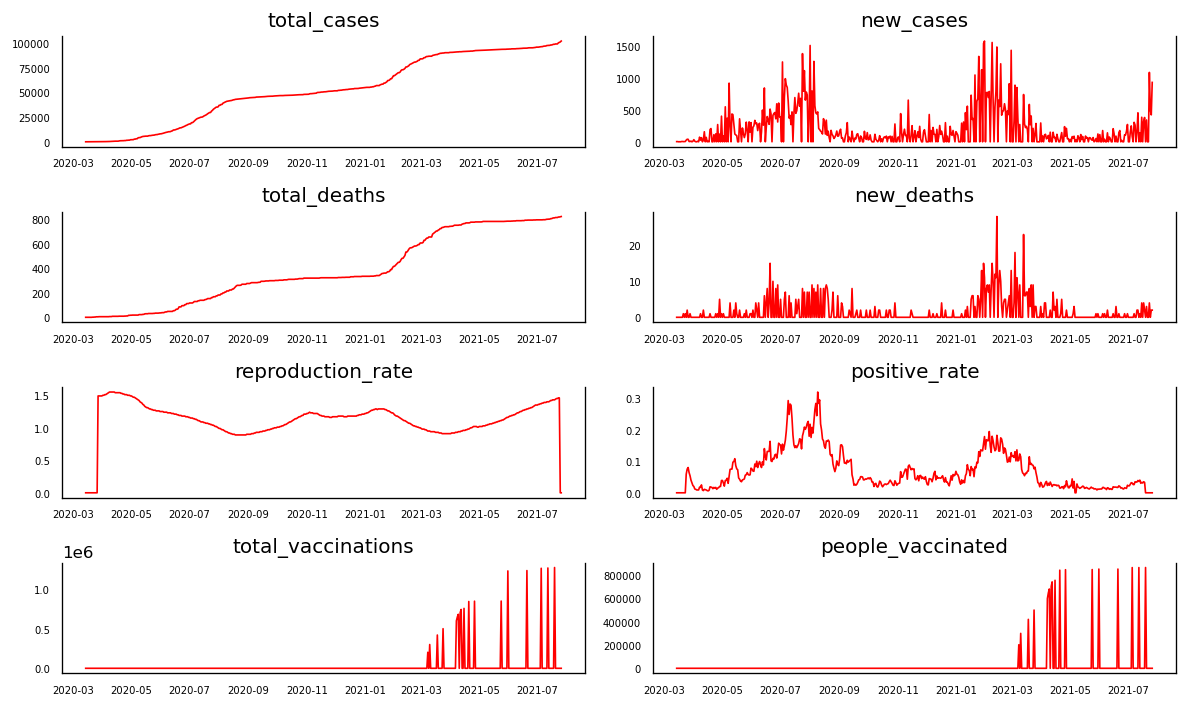

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [4]:
ad_fuller_result_1 = adfuller(dataset['new_cases'].diff()[1:])

print('cases')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(dataset['new_deaths'].diff()[1:])

print('deaths')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

cases
ADF Statistic: -12.29225906489613
p-value: 7.7792531920952e-23

---------------------

deaths
ADF Statistic: -6.6038941412490155
p-value: 6.630520256548324e-09


In [5]:
dataset2=dataset[['new_cases','positive_rate']]
print(dataset.shape)

(500, 11)


In [6]:
train= dataset2.iloc[:-50]
test= dataset2.iloc[-50:]
print(train.shape,test.shape)

(450, 2) (50, 2)


In [7]:
model= VAR(train.diff()[1:])

In [8]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.465       3.484       31.97       3.472
1        2.903       2.960       18.23       2.925
2        2.660       2.755       14.30       2.697
3        2.492       2.624       12.08       2.544
4        2.472       2.642       11.84       2.539
5        2.465       2.673       11.76       2.547
6        1.585       1.832       4.881       1.683
7        1.539      1.823*       4.661      1.651*
8        1.558       1.880       4.748       1.685
9        1.567       1.926       4.791       1.709
10       1.559       1.956       4.753       1.716
11       1.549       1.984       4.706       1.721
12       1.546       2.020       4.696       1.733
13      1.486*       1.997      4.420*       1.688
14       1.497       2.046       4.471       1.714
15       1.506       2.093       4.513       1.738
16       1.518       2.143     

In [9]:
var_model = VARMAX(train, order=(7,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['new_cases', 'positive_rate']   No. Observations:                  450
Model:                                     VAR(7)   Log Likelihood               -1610.296
                                      + intercept   AIC                           3286.592
Date:                            Tue, 21 Sep 2021   BIC                           3422.197
Time:                                    09:37:08   HQIC                          3340.039
Sample:                                03-14-2020                                         
                                     - 06-06-2021                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             0.01, 1.15   Jarque-Bera (JB):      557.74, 1535.23
Prob(Q):                        0.93, 0.28   Prob(JB):                   0.00, 0.00
Heteroskedast

In [10]:
n_forecast = 50
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)#start="2021-06-07",end='2021-07-26')

predictions=predict.predicted_mean

In [11]:
predictions.columns=['new_cases_predicted','positive_rate_predicted']
predictions

,new_cases_predicted,positive_rate_predicted
2021-06-07,80.274177,0.017746
2021-06-08,81.172898,0.016176
2021-06-09,65.873373,0.019430
2021-06-10,82.847825,0.023017
2021-06-11,72.826856,0.018795
2021-06-12,90.751201,0.023245
2021-06-13,83.655119,0.024904
2021-06-14,94.967935,0.025719
2021-06-15,79.705655,0.026224
2021-06-16,97.216131,0.027680


In [12]:
test_vs_pred=pd.concat([test,predictions],axis=1)


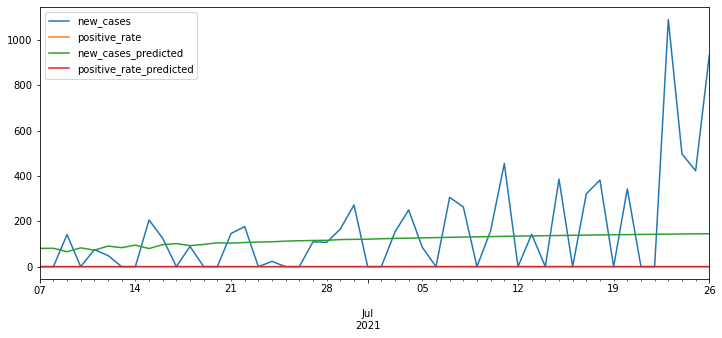

In [16]:
test_vs_pred.plot(figsize=(12,5))
plt.savefig('var testvspred newcases.png')

In [14]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_new_cases=math.sqrt(mean_squared_error(predictions['new_cases_predicted'],test['new_cases']))
print('Mean value of new cases is : {}. Root Mean Squared Error is :{}'.format(mean(test['new_cases']),rmse_new_cases))

rmse_positive_rate=math.sqrt(mean_squared_error(predictions['positive_rate_predicted'],test['positive_rate']))
print('Mean value of positive rate is : {}. Root Mean Squared Error is :{}'.format(mean(test['positive_rate']),rmse_positive_rate))

Mean value of new cases is : 157.5. Root Mean Squared Error is :220.5249988539345
Mean value of positive rate is : 0.01882. Root Mean Squared Error is :0.023576950219758076


In [15]:
from sklearn.metrics import mean_absolute_error
mae_new_cases=mean_absolute_error(predictions['new_cases_predicted'],test['new_cases'])
print('Mean absolute error of new cases is:',mae_new_cases)

mae_positive_rate=(mean_absolute_error(predictions['positive_rate_predicted'],test['positive_rate']))
print('Mean absolute error of positive rate is:',mae_positive_rate)

Mean absolute error of new cases is: 143.79638339837925
Mean absolute error of positive rate is: 0.018880492547435665
